In [1]:
import pandas as pd
import numpy as np
from joblib import load
from tqdm.notebook import tqdm

In [2]:
#for the driver scheduling problem (aka how many drivers we need per )
mm = load('minimum_active_uber_trips')
print('Minute Range:', mm.index.max())
mm.head(3)

Minute Range: 1439


,Driver Count,Hour
Minute,,
0,5161.489796,0.0
1,5060.322751,0.0
2,5076.383838,0.0


In [3]:
#generate bundles of 1k drivers at once, with their interval lengths and centers
#interval length from 2 - 10 hours (120 - 600 minutes)
#centers from 0 - 1439

def generate_bundle(size = 1000):
    centers = np.random.randint(1440, size = size)

    #weights 8 hour intervals higher than 2 hours
    possible_lengths = np.arange(60, 301) * 2
    length_pvalues = 1/(np.abs(480 - possible_lengths) + 15)
    length_pvalues = length_pvalues / length_pvalues.sum()
    lengths = np.random.choice(possible_lengths, size = size, p = length_pvalues)
    lengths.sort()
    return centers, lengths[::-1]

def update_availability_arr(availability, bundle, preferred_availability, acceptable_overlap = 60, show_progress = False):
    #add bundled centers and lengths to availability
    #up to the preferred availability
    mins = bundle[0] - bundle[1] / 2
    mins = np.where(mins >= 0, mins, 1440 + mins)
    maxs = bundle[0] + bundle[1] / 2
    maxs = np.where(maxs < 1440, maxs, maxs - 1440)
    bounds = np.c_[mins, maxs].astype(int)

    #transform bounds to np array (1440)
    #and iteratively add if it's okay to add
    updated_avail = availability
    accepted_drivers = []
    if show_progress:
        iterable_shown = tqdm(range(len(bounds)), position = 0, leave = True, desc = 'Transforming bounds to arrays')
    else:
        iterable_shown = range(len(bounds))
    for i in iterable_shown:
        new_arr = np.zeros(1440)
        s, e = bounds[i][0], bounds[i][1]
        if e < s:
            new_arr[s:] = 1
            new_arr[:e] = 1
        else:
            new_arr[s:e] = 1
        restricted = (preferred_availability - updated_avail <= 0).astype(int)
        if (new_arr + restricted == 2).sum() <= acceptable_overlap:
            accepted_drivers.append(i)
            updated_avail += new_arr
                        
    #filter out the bounded_arr
    diff = (updated_avail - preferred_availability)
    return updated_avail, diff, bounds[accepted_drivers]

def generate_driver_schedules(preferred_availability, 
    tolerated_under_preferred = 3000, 
    acceptable_overlap = 60, 
    chunk_size = 100000,
    show_progress = False):
    avail = np.zeros(1440)
    avail, diff, schedules = update_availability_arr(avail, generate_bundle(chunk_size), preferred_availability, acceptable_overlap, show_progress)
    print(f'Maximu Difference between # Drivers Available and Preferred Amount: {diff.min().round()}', end = ' ')
    while diff.min() <= -tolerated_under_preferred:
        avail, diff, s2 = update_availability_arr(avail, generate_bundle(chunk_size), preferred_availability, acceptable_overlap, show_progress)
        print(diff.min().round(), end = ' ')
        schedules = np.append(schedules, s2, axis = 0)
    print()
    return schedules


In [4]:
pickup_data = pd.read_pickle('arrival_and_dropoff_distributions')
hourly_arrival_rate =  pickup_data.apply(lambda item: item[0])
dropoff_frequency  = pickup_data.apply(lambda  item: item[1] / item[1].sum())
trip_time_data = pd.read_parquet('trip_time_means')
trip_time_data.head(3)

mean        std        min         max  count
pulocationid                                                      
1            1  19.037500  17.794296   2.716667   55.000000    8.0
             2   0.000000   0.000000   0.000000    0.000000    0.0
             3  54.540476  15.923260  34.650000  100.883333   14.0

In [34]:
from city_elements import *
from city import *
from event_list import *

def generate_arrivals_per_zone(zone_hourly_arrivals = hourly_arrival_rate, 
                               zone_dropoff_frequencies = dropoff_frequency, 
                               zone_to_zone_times = trip_time_data, 
                               one_list = True,
                               show_progress_bar = False):
    
    #check to make sure the indices match
    assert (zone_hourly_arrivals.index == zone_dropoff_frequencies.index).all()
    
    zone_arrivals = []
    #for each zone, generate a day's worth of arrivals
    iterable = zone_hourly_arrivals.index if not show_progress_bar else tqdm(zone_hourly_arrivals.index, position = 0, leave = True, desc = 'Zone Arrivals Generated')
    for i in iterable:
        
        hourly_rates = zone_hourly_arrivals.loc[i]
        dropoff_dist = zone_dropoff_frequencies.loc[i]
        zone_service_times = zone_to_zone_times.loc[i]
                
        max_rate = hourly_rates.max()
        #rate = max_rate / 60 minutes (since max_rate is in minutes)
        #input the inverse as the mean interarrival time (scale parameter for np.random.exponential)
        temp_interarrivals = np.random.exponential(scale = 60/max_rate, size = 25000)
        while temp_interarrivals.cumsum().max() <= 24 * 60:
            temp_interarrivals = np.append(temp_interarrivals, np.random.exponential(scale = 60/max_rate, size = 25000))
        
        #this cuts off interarrivals at 1 day
        interarrivals = temp_interarrivals[temp_interarrivals.cumsum() <= 24*60]
        arrivals = interarrivals.cumsum()
                
        #thinning process
        #uses constant hourly rate (like a 24 part step function) to generate the thinning probabilities
        keep_probability = (hourly_rates[(arrivals // 60).astype(int)] / max_rate).values
        unif = np.random.uniform(size = arrivals.shape[0])
        kept_arrivals = arrivals[unif <= keep_probability]
                
        #for each arrival generate from the dropoff distribution
        dropoffs = np.random.choice(dropoff_dist.index, size = kept_arrivals.shape[0], p = dropoff_dist)
                              
        #generate data in the form of (time, dropoff location id, pickup location id)
        arrival_data = np.vstack([kept_arrivals, dropoffs, i*np.ones(kept_arrivals.shape[0])]).T
        
        #format into dataframe
        arrival_df = pd.DataFrame(data = arrival_data, columns = ['time','dolocationid','pulocationid'])
        
        #each arrival, generate a service time from the service time distributions
        #this is SLOW
        if len(arrival_df) > 0:
            services = [max(np.random.normal(loc = info[0], scale = info[1]), 0)
                        for info in zone_service_times.loc[arrival_df.dolocationid].values]

            arrival_df['service'] = services

            zone_arrivals.append(arrival_df)
    
    #if one list, then combine everything into one big arrival matrix
    #otherwise, just return the list of arrival dataframes
    if one_list:
        zone_arrivals = pd.concat(zone_arrivals).sort_values('time').reset_index(drop=True)
    
    return zone_arrivals

def simulate_with_individual_drivers(arrivals,
                                     driver_distribution = 'proportional',
                                     preferred_driver_availability = 3*mm['Driver Count'].values,
                                     odmatrix = trip_time_data,
                                     pickup_data = hourly_arrival_rate):
    #convert arrivals into passengers, and then into events
    passengers = []
    drivers = []
    
    initial_events = deque()
    for a in tqdm(arrivals.values, position = 0, leave = True, desc = 'Passenger Objects Created'):
        p = Passenger(a[0], a[1], a[2], a[3])
        passengers.append(p)
        initial_events.append(Arrival(p))
    
    #setup drivers and zones based on driver_distribution parameter
    #setup driver schedules and insert driver arrivals and departures into the initial event list 
    #everything is under the city class
    if driver_distribution == 'proportional':

        #generate driver schedules
        dschedules = generate_driver_schedules(preferred_driver_availability)
        driver_count = len(dschedules)
        
        pbar = tqdm(total = driver_count, position = 0, leave = True, desc = 'Driver Objects Created')
        #number of drivers per zone
        #use the pickup data to do this
        arrivals_per_zone = pickup_data.sum(axis=1)
        dcounts = np.floor(driver_count * (arrivals_per_zone / arrivals_per_zone.sum()))
        
        driver_index = 0
        for i in dcounts.index:
            for j in range(int(dcounts.loc[i])):
                d = Driver(i, dschedules[driver_index][0], dschedules[driver_index][1])
                #also want to add the driver departure and arrival to the initial event list
                initial_events.append(DriverArrival(d))
                initial_events.append(DriverDeparture(d))
                drivers.append(d)
                pbar.update(1)
                driver_index += 1
        
        for i in range(driver_count - len(drivers)):
            z = np.random.choice(np.arange(1,264))
            d = Driver(z, dschedules[driver_index][0], dschedules[driver_index][1])
            initial_events.append(DriverArrival(d))
            initial_events.append(DriverDeparture(d))
            drivers.append(d)
            pbar.update(1)
            driver_index += 1
                    
        city = City('NYC', np.arange(1,264), drivers, odmatrix)

    event_list = EventList(initial_events)
            
    #iterate through the event list until no events left
    pbar = tqdm(total = arrivals.shape[0], position = 0, leave = True, desc = 'Passengers Processed')
    while not event_list.is_finished():
        
        event = event_list.iterate_next_event()

        result = city.process_event(event)
        if event.type == 'Trip':
            pbar.update(1)

        if result is not None:
            event_list.insert_event(result)    
                
    return passengers, drivers, city, event_list

In [35]:
arrivals = generate_arrivals_per_zone(show_progress_bar=True)

Zone Arrivals Generated:   0%|          | 0/259 [00:00<?, ?it/s]

In [36]:
p, d, c, e = simulate_with_individual_drivers(arrivals)

Passenger Objects Created:   0%|          | 0/455303 [00:00<?, ?it/s]

Maximu Difference between # Drivers Available and Preferred Amount: -10137.0 -8785.0 -7939.0 -7299.0 -6760.0 -6294.0 -5837.0 -5416.0 -4996.0 -4567.0 -4205.0 -3931.0 -3694.0 -3514.0 -3353.0 -3243.0 -3112.0 -3014.0 -2915.0 


Driver Objects Created:   0%|          | 0/58398 [00:00<?, ?it/s]

Passengers Processed:   0%|          | 0/455303 [00:00<?, ?it/s]

In [37]:
print(c.formatted_stats())
print(e.formatted_stats())


	-- generating_movement_times --
	Total Time Spent: 7.988728761672974
	# of Occurences: 455303
	-- choose_driver --
	Total Time Spent: 0
	# of Occurences: 0

	-- insertion speed --
	Total Time Spent: 12.091094255447388
	# of Occurences: 932036
	-- pop speed --
	Total Time Spent: 0.3606855869293213
	# of Occurences: 1504135
	-- search speed --
	Total Time Spent: 67.4203577041626
	# of Occurences: 932036


In [38]:
waiting_time = pd.DataFrame(np.array([(pe.time, pe.departure_time,pe.waiting_time()) for pe in p]).round(2), columns = ['time','departure','wait'])

<AxesSubplot:xlabel='hour', ylabel='wait'>

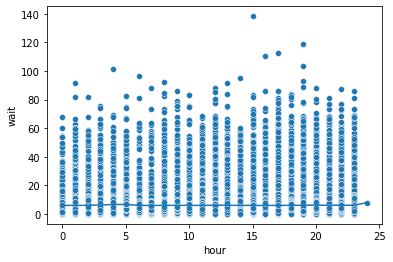

In [39]:
import seaborn as sns

waiting_time['hour'] = waiting_time.time // 60
hourly_wait_time = waiting_time.groupby('hour').wait.mean()
sns.scatterplot(data = waiting_time, x = 'hour', y = 'wait')
sns.lineplot(x = hourly_wait_time.index, y = hourly_wait_time)